# Sparx Technical Task

*Author: Ricky Hui*


In [2]:
# Core libraries
import pandas as pd
import numpy as np
import scipy

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from scipy.stats import ttest_ind, mannwhitneyu

In [3]:
#Import Library from helpers.py
from helpers import clean_data, summary_statistics, plot_correlation_matrix, plot_distributions, check_normality, bootstrap_ci, run_hypothesis_test



# Basic Data Analysis

In [4]:
qla_df = pd.read_csv("data/task_qla_df.csv")

In [8]:
tia_df = pd.read_feather("data/task_tia_df.feather")

In [10]:
#Check null value
summary_statistics(qla_df)

Shape: (5827, 11)

Missing Values:
 student_id                0
assessment_id             0
assessment_name           0
n_questions_entered       0
n_questions_attempted     0
n_assessment_questions    0
absent                    0
mark                      5
available_marks           0
created                   0
last_updated              0
dtype: int64

Descriptive Statistics:
        n_questions_entered  n_questions_attempted  n_assessment_questions  \
count          5827.000000            5827.000000             5827.000000   
mean             41.247812              39.998455               41.327270   
std               5.462259               6.800439                5.207156   
min               0.000000               0.000000               34.000000   
25%              36.000000              35.000000               36.000000   
50%              43.000000              43.000000               43.000000   
75%              46.000000              46.000000               46.000000   
m

In [11]:
summary_statistics(tia_df)

Shape: (459115, 14)

Missing Values:
 index                                0
student_id                           0
package_id                           0
first_start_time                 55211
last_start_time                  55211
task_index                           0
task_item_index                      0
assigned_number_homeworks_ago     4095
learning_unit_id                     0
question_id                          0
n_times_prior_correct                0
summary                          55211
time_to_first_correct            65125
video_time                       55211
dtype: int64

Descriptive Statistics:
               index  task_index  task_item_index  \
count  4.591150e+05    459115.0         459115.0   
mean   5.739950e+05    3.324635         3.617118   
std    3.312482e+05    1.663589         2.166633   
min    7.000000e+00         1.0              1.0   
25%    2.876500e+05         2.0              2.0   
50%    5.740650e+05         3.0              3.0   
75%    8.6073

# Mandatory Questions

### 1. How many distinct students do we have both assessment and activity data for?

In [14]:
# Find the distinct students ID with unique function
qla_students = set(qla_df["student_id"].unique())
tia_students = set(tia_df["student_id"].unique())

# Students that appears in both dataset
students_both = qla_students & tia_students
print(f"There are {len(students_both)} students that we have both assessment and activity.")


There are 1394 students that we have both assessment and activity.


#### 2. For students with more than 2 assessments, what was the mean progress from one test to the next?

In [15]:
qla_df.head()

,student_id,assessment_id,assessment_name,n_questions_entered,n_questions_attempted,n_assessment_questions,absent,mark,available_marks,created,last_updated
0,b61c4,94245,Year 7 Term 3 Assessment,36,36,36,False,34.0,60,2024-06-27 14:18:23.948111+00:00,2024-06-27 14:22:34.230140+00:00
1,d47b3,94245,Year 7 Term 3 Assessment,36,36,36,False,37.0,60,2024-07-08 13:52:46.036772+00:00,2024-07-08 14:24:42.552651+00:00
2,01093,94245,Year 7 Term 3 Assessment,36,36,36,False,42.0,60,2024-07-03 08:08:21.592102+00:00,2024-07-03 08:22:59.515326+00:00
3,2a270,94245,Year 7 Term 3 Assessment,36,36,36,False,27.0,60,2024-07-04 07:52:38.344720+00:00,2024-07-04 08:21:34.395024+00:00
4,24de5,94245,Year 7 Term 3 Assessment,36,36,36,False,37.0,60,2024-07-13 18:57:19.360425+00:00,2024-07-13 19:30:58.809699+00:00


In [22]:
filter_students = qla_df.groupby("student_id").filter(lambda x: len(x) >= 2)
filter_students_sorted = filter_students.sort_values(by=["student_id", "last_updated"])
filter_students_sorted = filter_students_sorted[filter_students_sorted["absent"] == False].dropna(subset=["mark"])

progress_list = []
# Calculate per-student progress
for student_id, group in filter_students_sorted.groupby("student_id"):
    if len(group) >= 2:
        scores = group["mark"].values
        deltas = [scores[i+1] - scores[i] for i in range(len(scores)-1)]
        progress_list.extend(deltas)

mean_progress = np.mean(progress_list)
print("Mean Progress (score difference between assessments):", mean_progress)

Mean Progress (score difference between assessments): -1.9017980636237897


####  The mean progess is -1.9017980636237897 score, which indicated that students are not improving over time, and their marks are slightly declining.


# 3. Plot/visualise this ‘progress’ distribution


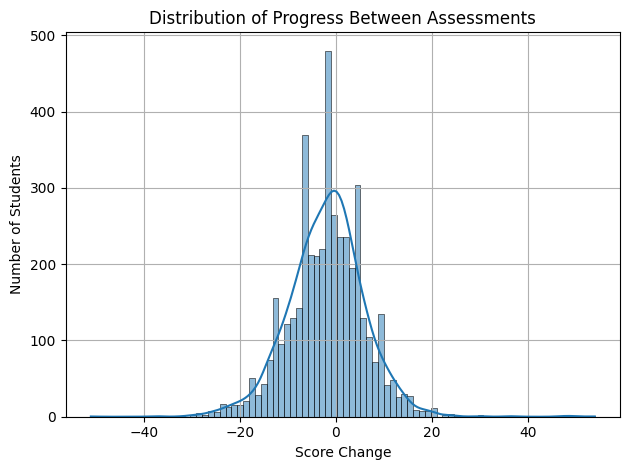

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(progress_list, kde=True)
plt.title("Distribution of Progress Between Assessments")
plt.xlabel("Score Change")
plt.ylabel("Number of Students")
plt.grid(True)
plt.tight_layout()
plt.show()

### While the distribution is approximately bell-shaped and centered near zero, it is slightly skewed to the left, reflecting a small average decline in scores. The presence of long tails on both sides suggests that some students experienced large improvements or declines, indicating potential outliers. These patterns may reflect varying levels of engagement, assessment difficulty, or learning support across the cohort.

### 4. On average, how did students perform in the second test that they sat compared to the first? Use a statistical test to explain whether or not you are confident in this result.

 To understand whether students really perform worse in the second test, a one-tailed paired test will be used here to find the result.

### Null Hypothesis (H0):Students performed equally or better in Assessment 2.

H 
0
​
 :μ 
Assessment2
​
 ≥μ 
Assessment1
​

### Alternative Hypothesis (H1):Students performed worse in Assessment 2.


H 
1
​
 :μ 
Assessment2
​
 <μ 
Assessment1
​



In [27]:
assessment1 = []
assessment2 = []

# Reuse your already filtered & sorted DataFrame
for student_id, group in filter_students_sorted.groupby("student_id"):
    if len(group) >= 2:
        scores = group["mark"].values
        assessment1.append(scores[0])  # First test
        assessment2.append(scores[1])  # Second test

In [28]:
from scipy.stats import ttest_rel

stat, p = ttest_rel(assessment2, assessment1, alternative='less')
print("Paired one-tailed t-test p-value:", p)

Paired one-tailed t-test p-value: 3.595998029494931e-41


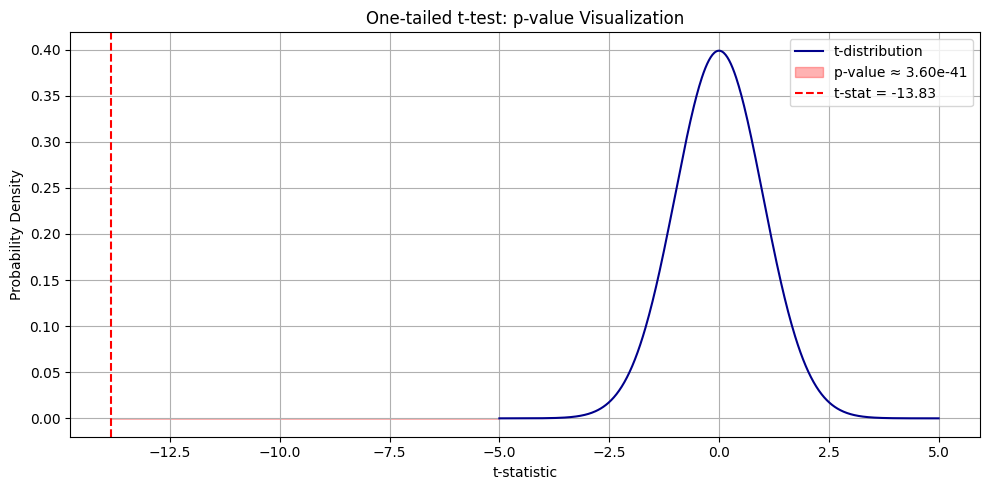

In [32]:
from scipy.stats import t

# Assuming you already have assessment1 and assessment2
stat, p = ttest_rel(assessment2, assessment1, alternative='less')

df = len(assessment1) - 1  # degrees of freedom
x = np.linspace(-5, 5, 500)
y = t.pdf(x, df)

# Plotting the t-distribution
plt.figure(figsize=(10, 5))
plt.plot(x, y, label="t-distribution", color="darkblue")

# Shade p-value region (left tail)
x_fill = np.linspace(-5, stat, 300)
plt.fill_between(x_fill, t.pdf(x_fill, df), color="red", alpha=0.3, label=f"p-value ≈ {p:.2e}")

# Draw t-statistic line
plt.axvline(stat, color="red", linestyle="--", label=f"t-stat = {stat:.2f}")

plt.title("One-tailed t-test: p-value Visualization")
plt.xlabel("t-statistic")
plt.ylabel("Probability Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Hypothesis Result

The result shows a p-value with 3.60e-41, which falls in the 0.05 interval, so we can reject H0. And there is a strong statistical evidence that students performed worse in assessment 2 compared to assessment 1.

### 5. On average, how did students perform in the second test that they sat compared to the first? Use a statistical test to explain whether or not you are confident in this result.

 To ensure that the test is significant, i will visualize the uncertainity by bootstrapping the mean difference to get the confidence Intervals.

In [33]:
# comparing the scores of students from assesment 1 and 2
diff = np.array(assessment2) - np.array(assessment1)


In [34]:
def bootstrap_ci(data, stat=np.mean, n_iterations=1000, ci=95, random_state=42):
    np.random.seed(random_state)
    stats = []
    for _ in range(n_iterations):
        sample = np.random.choice(data, size=len(data), replace=True)
        stats.append(stat(sample))
    lower = np.percentile(stats, (100 - ci) / 2)
    upper = np.percentile(stats, 100 - (100 - ci) / 2)
    return lower, upper, stats

In [35]:
ci_lower, ci_upper, bootstrap_stats = bootstrap_ci(diff, stat=np.mean, n_iterations=1000)

print(f"Bootstrapped 95% CI: ({ci_lower:.2f}, {ci_upper:.2f})")

Bootstrapped 95% CI: (-3.35, -2.52)


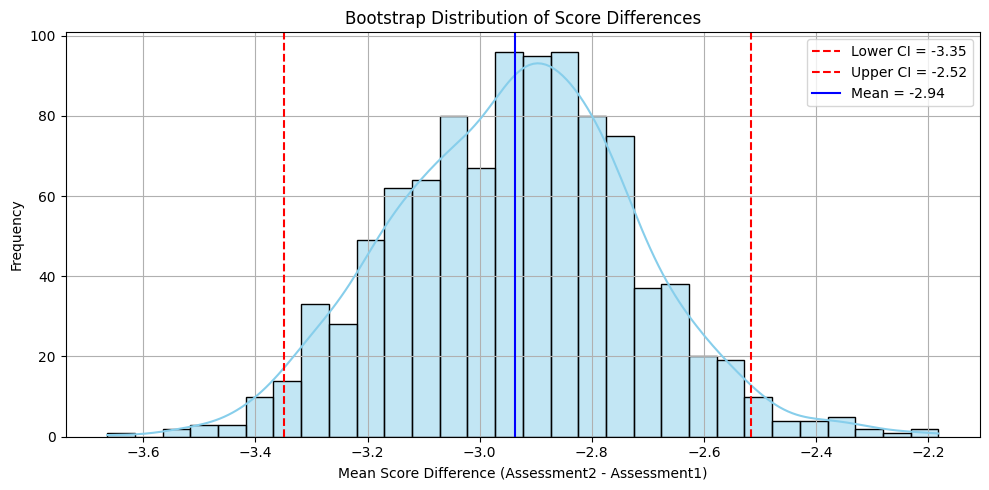

In [36]:
plt.figure(figsize=(10, 5))
sns.histplot(bootstrap_stats, bins=30, color="skyblue", kde=True)
plt.axvline(ci_lower, color="red", linestyle="--", label=f"Lower CI = {ci_lower:.2f}")
plt.axvline(ci_upper, color="red", linestyle="--", label=f"Upper CI = {ci_upper:.2f}")
plt.axvline(np.mean(bootstrap_stats), color="blue", linestyle="-", label=f"Mean = {np.mean(bootstrap_stats):.2f}")
plt.title("Bootstrap Distribution of Score Differences")
plt.xlabel("Mean Score Difference (Assessment2 - Assessment1)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Result
Using bootstrapping, we find that the average score decreased between assessments.Since the entire confidence interval is negative, we are highly confident that this is not due to random variation.



# Exploratory question

To evaluate whether using Sparx improves students' exam performance, we focused on one of its core features: support videos. These videos are designed to reinforce concepts and promote self-directed learning — a key component of the Sparx platform.

We hypothesize that students who engage more with support videos will demonstrate better performance in their assessments. To test this, we divided students into high-engagement and low-engagement groups based on the total time they spent watching support videos, and compared their assessment scores statistically.

In [37]:
# Aggregate total video time per student
video_engagement = tia_df.groupby("student_id")["video_time"].sum().reset_index()

In [38]:
# Merge with mean assessment scores
scores = qla_df[qla_df["absent"] == False].groupby("student_id").agg({
    "mark": "mean",
    "available_marks": "mean"
}).reset_index()

scores["score_pct"] = scores["mark"] / scores["available_marks"]

merged = pd.merge(video_engagement, scores, on="student_id")

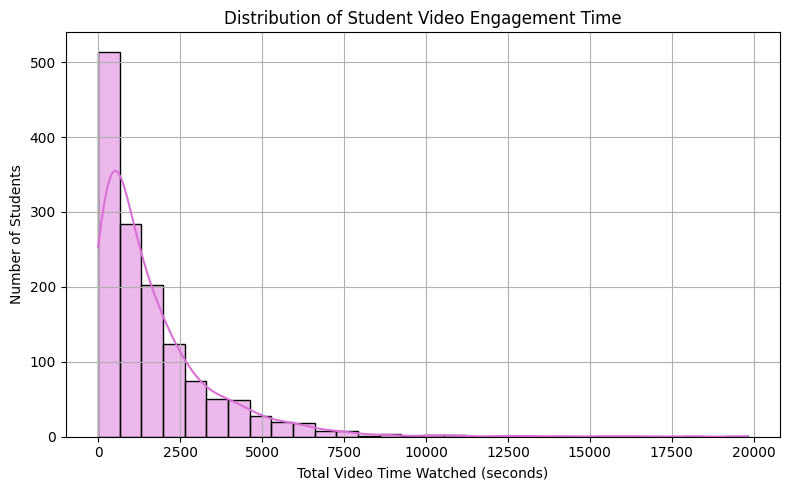

In [40]:
# Visualize the engagement time in support video
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.histplot(merged["video_time"], bins=30, kde=True, color="orchid", edgecolor="black")
plt.title("Distribution of Student Video Engagement Time")
plt.xlabel("Total Video Time Watched (seconds)")
plt.ylabel("Number of Students")
plt.grid(True)
plt.tight_layout()
plt.show()



The distribtion of students video engagement is heavily right skewed, meaning that most students spent a relatively short amount of time watching support videos (under ~2000 seconds), and a small number of students spent a significantly higher amount of time watching videos (long tail up to 20,000 seconds). This long-tailed distribution suggests that a majority of students are low-to-moderate users of video support, while a few are heavy users. The result indicate that most students did not properly use the support video function, which explains why students might not have improvement for second assessment.

### Hypothesis test: Do high-video users perform better?

Null Hypothesis (H₀):
Students in the high-video engagement group have the same or lower assessment scores compared to those in the low-video engagement group.

Alternative Hypothesis (H₁):
Students in the high-video engagement group have higher assessment scores on average.


In [42]:
### Now we will splot students into twp groups(High engagement, Low engagement), As the data are heavily skewed to right, we will take the higher engagement for higher quartile only.
high_thresh = merged["video_time"].quantile(0.7)
low_thresh = merged["video_time"].quantile(0.3)

high_group = merged[merged["video_time"] >= high_thresh]["score_pct"]
low_group = merged[merged["video_time"] <= low_thresh]["score_pct"]


In [43]:
# Perform one-tailed t-test (alternative: mean of high_group > mean of low_group)
from scipy.stats import ttest_ind

stat, p = ttest_ind(high_group, low_group, equal_var=False, alternative='greater')

print("High Engagement Mean:", high_group.mean())
print("Low Engagement Mean:", low_group.mean())
print(f"Welch’s t-test p-value: {p:.4f}")

High Engagement Mean: 0.5453702437912965
Low Engagement Mean: 0.5052152160704793
Welch’s t-test p-value: 0.0069


### Conclusion:
We grouped students into high and low video engagement categories based on the 70th and 30th percentiles of total video time watched. A Welch’s t-test comparing assessment performance showed that high-engagement students scored significantly higher on average (p = 0.0069). This provides statistical evidence that students who engage more with Sparx support videos tend to perform better.

In [ ]:
X = df[['Age', 'Quiz_Scores']]
y = df['Final_Exam_Score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Model 1: Linear Regression

In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)
print(f"Linear Regression MAE: {mae_lr:.2f}, R²: {r2_lr:.2f}")

Model 2: Decision Tree Regressor

In [ ]:
tree = DecisionTreeRegressor(max_depth=3, random_state=42)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)
mae_tree = mean_absolute_error(y_test, y_pred_tree)
r2_tree = r2_score(y_test, y_pred_tree)
print(f"Decision Tree MAE: {mae_tree:.2f}, R²: {r2_tree:.2f}")

In [ ]:
cv_scores = cross_val_score(tree, X, y, cv=5, scoring='neg_mean_absolute_error')
print(f"Decision Tree CV MAE: {-cv_scores.mean():.2f}")

# Stretch Question

#In practice, we don’t have assessment data for all students. Suggest how modelling the data provided could be useful when personalising all students’ homework. This can be a hypothetical model that you’ve not attempted to fit. If so, briefly outline your proposed model structure.

<Axes: xlabel='score_pct', ylabel='unanswered'>

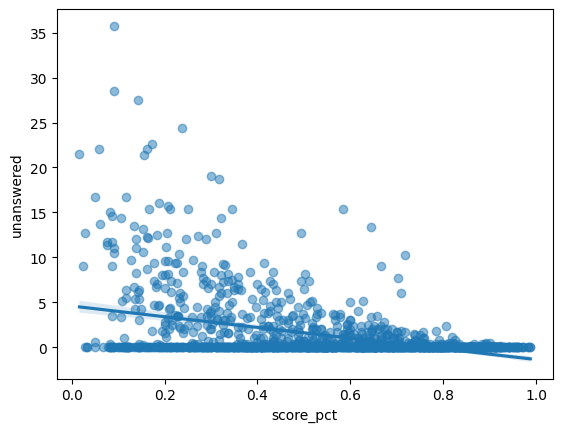

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Filter non-absent assessments
filtered = qla_df[qla_df["absent"] == False].copy()

# Step 2: Calculate score percentage and unanswered questions
filtered["score_pct"] = filtered["mark"] / filtered["available_marks"]
filtered["unanswered"] = filtered["n_assessment_questions"] - filtered["n_questions_attempted"]

# Step 3: Aggregate per student
agg = filtered.groupby("student_id").agg({
    "score_pct": "mean",
    "unanswered": "mean"
}).reset_index()

# Step 4: Plot
sns.regplot(data=agg, x="score_pct", y="unanswered", scatter_kws={"alpha":0.5})


From the last part of the exploratory questions, I have noticed that most students have a low tendenct in watching a support video for the question. To create a more personalised model for student , I would focus more on how to model and explore how to improve the engagement level of the lower-performing students who tends to skip more questions. The scatter plot reveals a clear negative relationship: students with lower score percentages generally leave more questions unanswered. This suggests that disengagement or difficulty may lead to incomplete assessments, reinforcing the importance of early intervention and engagement monitoring.

### Approach
High-performing students often demonstrate strong initiative and can effectively utilize the learning platform with minimal intervention. Therefore, I suggest that a personalized model should focus more on student engagement levels. Higher engagement typically reflects a greater willingness to learn, increased motivation, and a higher likelihood of sustained success. By tailoring homework based on engagement signals—such as time spent on support videos or repeated attempts at challenging tasks—we can provide the right level of support to encourage consistent progress and long-term academic growth.

### Proposed Model Plan
To achieve this, I propose building a probabilistic machine learning model, inspired by Bayesian Knowledge Tracing, that estimates each student’s mastery of various topics using engagement data alone. The model would use features such as:

- Time spent per task or question

- Number of video views

- Frequency of correct vs. incorrect attempts

- Time to first correct answer

- Question repetition and revisit patterns

The model would output a predicted mastery level for each topic, which could then guide homework personalization by:

- Assigning reinforcement tasks for students predicted to struggle

- Introducing more advanced problems for students with high predicted mastery

- Balancing revision with new learning for mid-level students

Over time, the model can be retrained as more data becomes available, making it increasingly accurate. By integrating this with a lightweight deployment (via API or container), it could be scaled efficiently across the platform and serve real-time recommendations with minimal overhead.


